In [242]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math


In [244]:
drive_url = "https://drive.google.com/file/d/1AKGbyGNYPjCgvovXhAnv6m225ceT6Om1/view?usp=sharing"
file_id = drive_url.split('/')[5]
url = f"https://drive.google.com/uc?export=download&id={file_id}"

In [245]:
df_house = pd.read_csv(url)

In [246]:
df_house.shape

(21742, 58)

In [247]:
def clean_dataframe(df_to_clean, col_keep, cols_descart, spa_eng_dict):

  # define max null cols
  maxim_null_por_columna = df_to_clean.shape[0] * 0.5
  nulls= df_to_clean.isna().sum()
  na_cols= []
  for col,na in nulls.items():
      if na >= maxim_null_por_columna:
          na_cols.append(col)

  # drop cols that exceed limit number of null values
  df = df_to_clean.drop(axis=1,columns=na_cols)
  df[col_keep]= df_to_clean[col_keep]

  # get neightbourhood and district column
  chop = df['neighborhood_id'].str.extract(r'Neighborhood (\d+): (.*?) \(.*\) - District (\d+): (.*)')
  df['neighbourhood']= chop[1]+ ' ' +chop[0]
  df['district']= chop[3] + ' ' + chop[2]

  # drop neighborhood_id column & cols_descart columns
  df.drop(axis=1, columns=['neighborhood_id'], inplace=True)
  df = df.drop(axis=1,columns=cols_descart)

  # drop duplicated
  df = df.drop_duplicates()

  # get house type from title and drop house_type_id and title columns
  df['house_type'] = df['title'].apply(lambda x: x.split(' ')[0] if x[0] != ' ' else x.split(' ')[1])
  df = df.drop(axis=1,columns=['house_type_id','title'])

  # drop buy_price due to data leakage
  df = df.drop(axis=1,columns=['buy_price'])

  # use false for missing values under has_fitted_wardrobes and has_ac, which only have true values
  for column_unique_value in ['has_fitted_wardrobes', 'has_ac']:
    df[column_unique_value] = df[column_unique_value].apply(lambda x: False if type(x)==float else x)

  # convert Spanish words to English
  for column in df.columns:
    for key, value in spa_eng_dict.items():
      df[column] = df[column].replace(key, value)

  return df

In [248]:
cols_descart = ['Unnamed: 0','id', 'subtitle', 'raw_address', 'street_name', 'operation', 'is_rent_price_known',
                'is_buy_price_known']

In [249]:
spa_eng_dict = {
    'Bajo': 0,
    'Entreplanta exterior': 'Exterior mezzanine',
    'Entreplanta interior': 'Interior mezzanine',
    'Entreplanta': 'Mezzanine',
    'Sótano interior': 'Interior basement',
    'Sótano exterior': 'Exterior basement',
    'Sótano': 'Basement',
    'Semi-sótano exterior': 'Exterior semi-basement',
    'Semi-sótano interior': 'Interior semi-basement',
    'Semi-sótano': 'Semi-basement',
    'en trámite': 'in process',
    'inmueble exento': 'exempt property',
    'no indicado': 'not indicated',
    'Casa': 'House',
    'Chalet': 'Chalet',
    'Dúplex': 'Duplex',
    'Estudio': 'Studio',
    'Finca': 'Estate',
    'Piso': 'Apartment',
    'Ático': 'Penthouse'
}

In [250]:
df = clean_dataframe(df_house, 'built_year', cols_descart, spa_eng_dict)

In [251]:
def check_rare_occurrences(df, cols_to_exclude, rare_occs=[]):
  for column in df.columns:
    if column not in cols_to_exclude:
      df_col_sum = df[column].value_counts(normalize='all')
      for col, na in df_col_sum.items():
        if na<0.005:
          rare_occs.append((column, col, na))
  return rare_occs

In [252]:
cols_to_exclude = ['sq_mt_built', 'rent_price', 'buy_price_by_area', 'built_year']

In [253]:
rare_occs_list = check_rare_occurrences(df, cols_to_exclude)

In [254]:
rare_occ_dict = {
    'Exterior mezzanine': 'Mezzanine',
    'Interior mezzanine': 'Mezzanine',
    'Basement': 'Basement & Semi-basement',
    'Semi-basement': 'Basement & Semi-basement',
    'Interior basement': 'Basement & Semi-basement',
    'Exterior basement': 'Basement & Semi-basement',
    'Exterior semi-basement': 'Basement & Semi-basement',
    'Interior semi-basement': 'Basement & Semi-basement'
}

In [255]:
def remove_rare_occurrences(df, rare_occs_list, rare_occ_dict, additional_rare_list):
  p = inflect.engine()
  for item in rare_occs_list:
    for key, value in rare_occ_dict.items():
      df[item[0]] = df[item[0]].replace(key, value)
    if item[0] in additional_rare_list and item[2]<0.002:
      df[item[0]] = df[item[0]].replace(item[1], 'other')
  for num in range(10):
    if num == 0:
      df['floor'] = df['floor'].replace(num, p.number_to_words(num))
    else:
      df['floor'] = df['floor'].replace(str(num), p.number_to_words(num))
  return df

In [256]:
df = remove_rare_occurrences(df, rare_occs_list, rare_occ_dict, ['neighbourhood'])

In [257]:
def convert_bools_to_num(df):
  bool_cols = df.select_dtypes(include=['bool']).columns.tolist()
  for col in bool_cols:
    df[col] = df[col].astype('int')
  df = df.replace({True: 1, False: 0})
  return df

In [258]:
df = convert_bools_to_num(df)

In [259]:
columns_to_plot = [col for col in df.columns if col not in ['buy_price_by_area', 'sq_mt_built', 'rent_price', 'built_year', 'neighbourhood']]

In [260]:
def plot_columns_vs_target_y (df, columns_to_plot, y_col):
  num_rows = math.ceil(len(columns_to_plot)/3)
  fig, axs = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 40))
  axs = axs.flatten()

  for i, column in enumerate(columns_to_plot):
      if i < len(axs):
          sns.boxplot(y=y_col, x=column, data=df, ax=axs[i])
          axs[i].tick_params(axis='x', rotation=90)
          axs[i].set_title(column)

  for j in range(i + 1, len(axs)):
      fig.delaxes(axs[j])

  plt.tight_layout()
  plt.show()

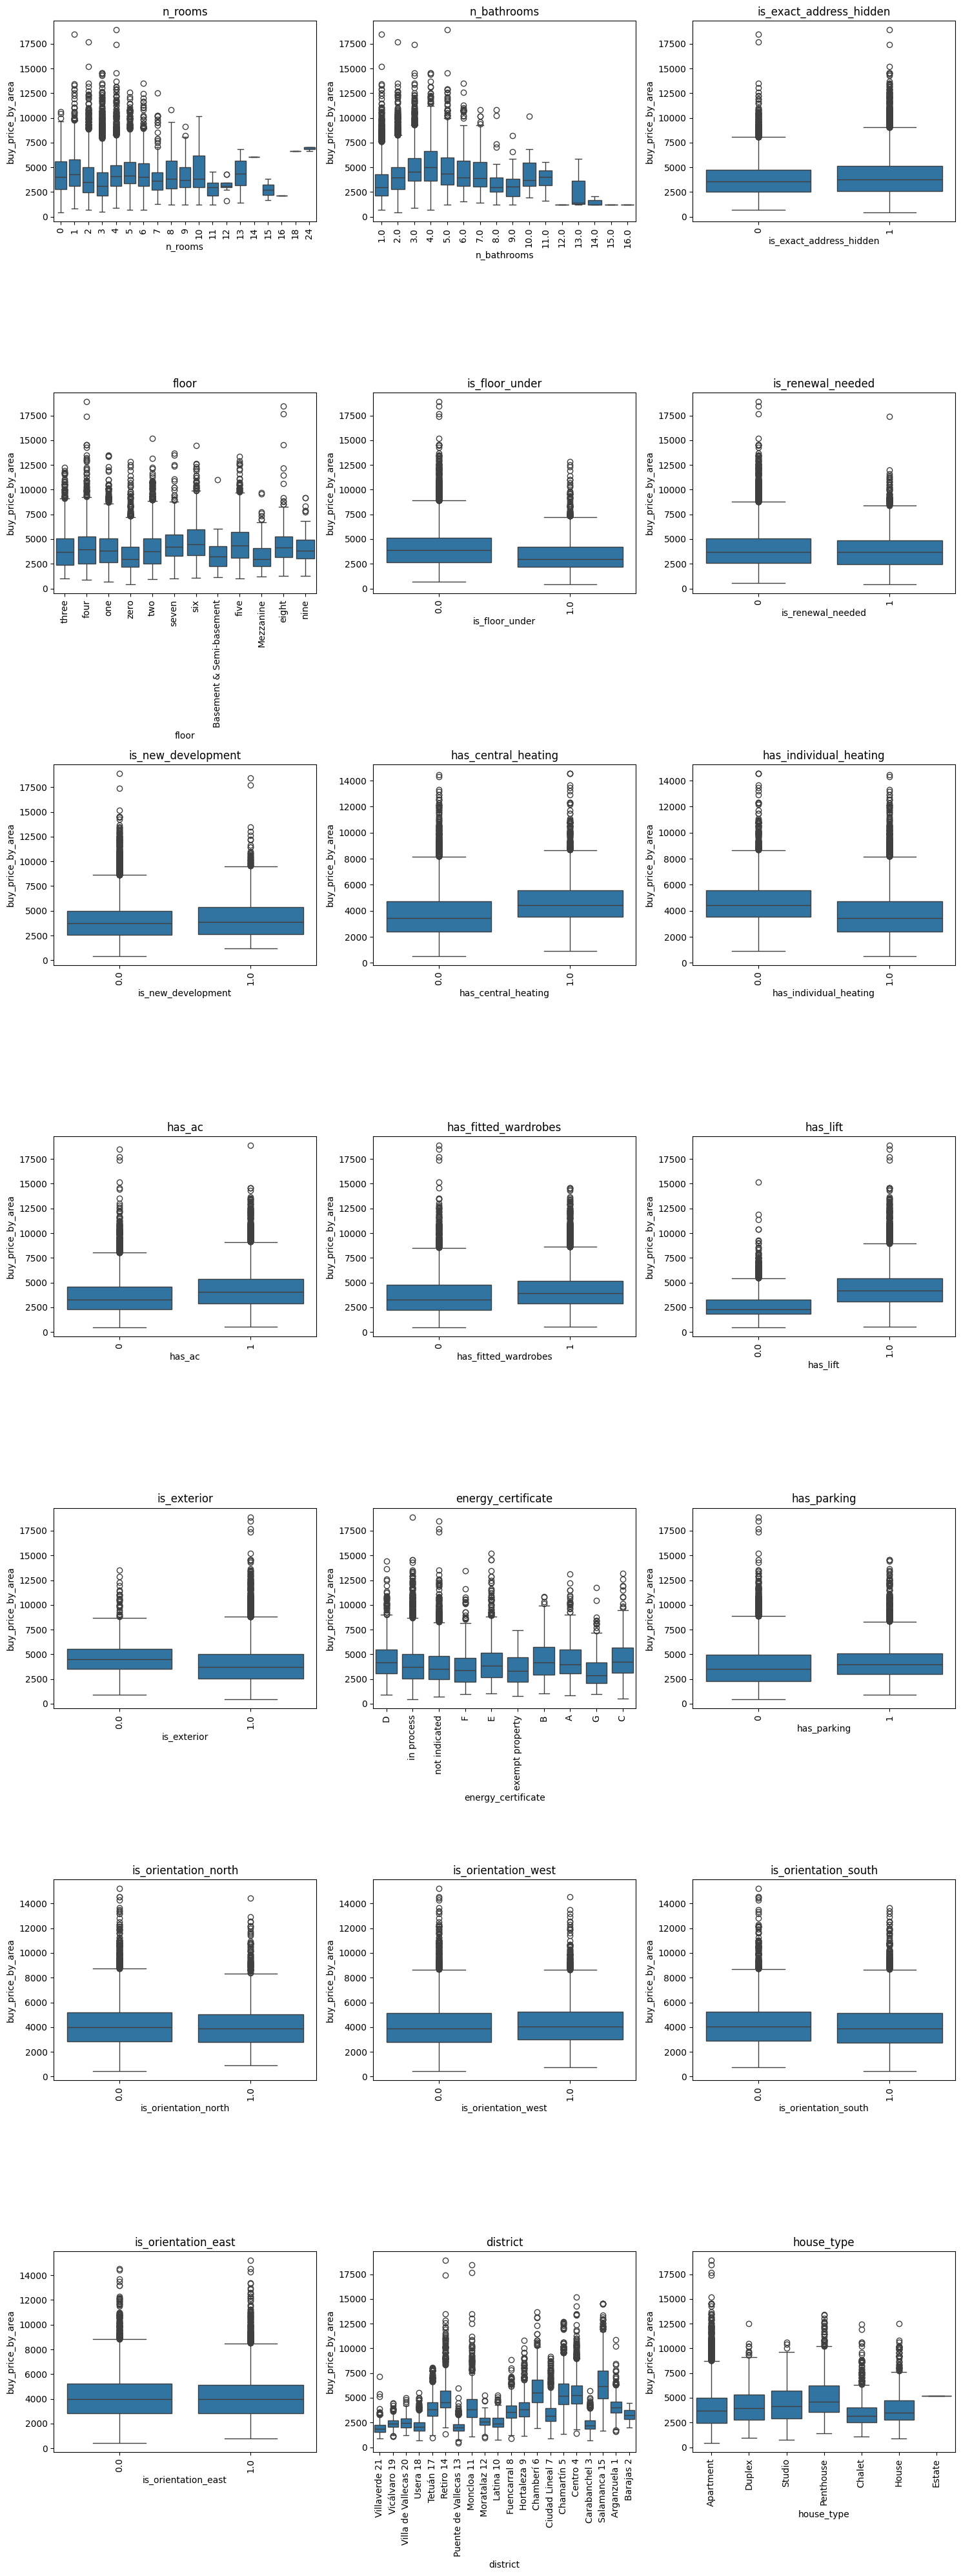

In [261]:
plot_columns_vs_target_y(df, columns_to_plot, 'buy_price_by_area')

In [262]:
def plot_distribution(df, column):
  plt.figure(figsize=(12, 6))
  sns.histplot(df[column], kde=True, color='blue', bins='fd')
  plt.title(f'{column} distribution')
  plt.show()

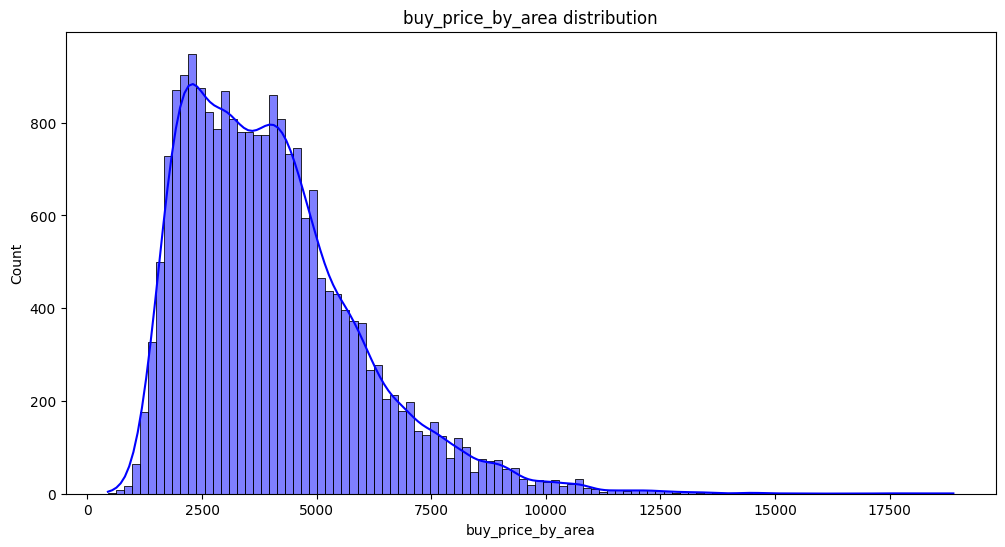

In [263]:
plot_distribution(df, 'buy_price_by_area')

In [266]:
df.to_csv('data/processed/cleaned_data_Emanuela.csv', index=False)